In [1]:
import torch
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from glob import glob
import pandas as pd
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
from sklearn.svm import SVC

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
imagePatches = glob('/kaggle/input/breast-histopathology-images/*/*/*')
imagePatches = [imagePatches[i] for i in range(len(imagePatches)) if 'IDC' not in imagePatches[i]]
len(imagePatches)

277524

In [4]:
y = []
for img in imagePatches:
    if img.endswith('class0.png'):
        y.append(0)
    elif img.endswith('class1.png'):
        y.append(1)

print(len(y))

277524


In [5]:
class MyDataset(Dataset):
    def __init__(self, df_data,transform=None):
        super().__init__()
        self.df = df_data.values

        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_path,label = self.df[index]

        image = cv2.imread(img_path)
        image = cv2.resize(image, (50,50))
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [6]:
images_df = pd.DataFrame()
images_df["images"] = imagePatches
images_df["labels"] = y
images_df.head()

,images,labels
0,/kaggle/input/breast-histopathology-images/102...,0
1,/kaggle/input/breast-histopathology-images/102...,0
2,/kaggle/input/breast-histopathology-images/102...,0
3,/kaggle/input/breast-histopathology-images/102...,0
4,/kaggle/input/breast-histopathology-images/102...,0


In [7]:
train, test = train_test_split(images_df, stratify=images_df.labels, test_size=0.2,random_state=42)
train, val = train_test_split(train, stratify=train.labels, test_size=0.2,random_state=42)
len(train), len(val),len(test)

(177615, 44404, 55505)

In [8]:
num_epochs = 30
num_classes = 2
batch_size = 128
learning_rate = 0.0001

In [9]:
import torchvision.models as models
densenet_model = models.densenet121(pretrained=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 126MB/s] 


In [10]:
densenet_model.classifier = torch.nn.Linear(in_features=1024, out_features=1)
densenet_model.sigmoid = torch.nn.Sigmoid()

In [14]:
densenet_model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [15]:
trans_train = transforms.Compose([transforms.ToPILImage(),
                                  transforms.Pad(10, padding_mode='reflect'),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.RandomVerticalFlip(),
                                  transforms.RandomRotation(20),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

trans_valid = transforms.Compose([transforms.ToPILImage(),
                                  transforms.Pad(10, padding_mode='reflect'),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

dataset_train = MyDataset(df_data=train, transform=trans_train)
dataset_valid = MyDataset(df_data=val,transform=trans_valid)
dataset_test = MyDataset(df_data=test,transform=trans_valid)

loader_train = DataLoader(dataset = dataset_train, batch_size=batch_size, shuffle=True, num_workers=0)
loader_valid = DataLoader(dataset = dataset_valid, batch_size=batch_size//2, shuffle=True, num_workers=0)
loader_test = DataLoader(dataset = dataset_test, batch_size=batch_size//2, shuffle=False, num_workers=0)

In [16]:
criterion = torch.nn.BCELoss().to(device)

In [17]:
optimizer = torch.optim.Adam(densenet_model.parameters(), lr=learning_rate)

In [18]:
best_accuracy = 0
best_weights = None

In [19]:
trl = []
trac = []
vall = []
valac = []

In [20]:
for epoch in range(num_epochs):
    train_loss = 0.0
    train_correct = 0
    densenet_model.train()
    for images, labels in loader_train:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = densenet_model(images)
        loss = criterion(densenet_model.sigmoid(outputs), labels.float().unsqueeze(1))
        loss.backward()
        optimizer.step()
        predictions = (densenet_model.sigmoid(outputs)>=0.5).float()

        train_loss += loss.item() * images.size(0)
        train_correct += (predictions == labels.float().unsqueeze(1)).sum().item()
    train_loss = train_loss / len(train)
    train_acc = train_correct / len(train)

    trl.append(train_loss)
    trac.append(train_acc)


    val_loss = 0.0
    val_correct = 0
    densenet_model.eval()
    with torch.no_grad():
        for images, labels in loader_valid:
            images, labels = images.to(device), labels.to(device)
            outputs = densenet_model(images)
            loss = criterion(densenet_model.sigmoid(outputs), labels.float().unsqueeze(1))
            predictions = (densenet_model.sigmoid(outputs)>=0.5).float()

            val_loss += loss.item() * images.size(0)
            val_correct += (predictions == labels.float().unsqueeze(1)).sum().item()
    val_loss = val_loss / len(val)
    val_acc = val_correct / len(val)

    vall.append(val_loss)
    valac.append(val_acc)

    if val_acc > best_accuracy:
            best_accuracy = val_acc
            best_weights = densenet_model.state_dict()

    print(f'Epoch {epoch + 1}/{num_epochs} train loss: {train_loss:.4f} train acc: {train_acc:.4f} '
          f'test loss: {val_loss:.4f} test acc: {val_acc:.4f}')

Epoch 2/30 train loss: 0.2462 train acc: 0.8964 test loss: 0.2401 test acc: 0.8999
Epoch 3/30 train loss: 0.2310 train acc: 0.9032 test loss: 0.2302 test acc: 0.9059
Epoch 4/30 train loss: 0.2202 train acc: 0.9079 test loss: 0.2201 test acc: 0.9100
Epoch 5/30 train loss: 0.2105 train acc: 0.9127 test loss: 0.2149 test acc: 0.9121
Epoch 6/30 train loss: 0.2023 train acc: 0.9161 test loss: 0.2203 test acc: 0.9084
Epoch 7/30 train loss: 0.1946 train acc: 0.9194 test loss: 0.2095 test acc: 0.9149
Epoch 8/30 train loss: 0.1866 train acc: 0.9231 test loss: 0.2065 test acc: 0.9162
Epoch 9/30 train loss: 0.1793 train acc: 0.9255 test loss: 0.2038 test acc: 0.9169
Epoch 10/30 train loss: 0.1723 train acc: 0.9287 test loss: 0.2071 test acc: 0.9162
Epoch 11/30 train loss: 0.1641 train acc: 0.9327 test loss: 0.2069 test acc: 0.9183
Epoch 12/30 train loss: 0.1559 train acc: 0.9358 test loss: 0.2092 test acc: 0.9200
Epoch 13/30 train loss: 0.1487 train acc: 0.9385 test loss: 0.2104 test acc: 0.9204


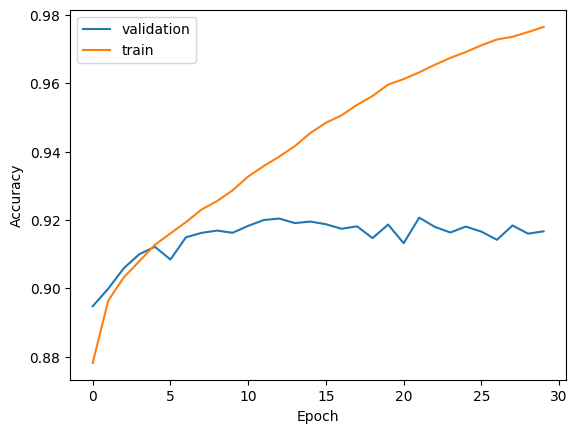

In [21]:
plt.plot(valac)
plt.plot(trac)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['validation','train'])

In [1]:
cuda_tensor = torch.tensor(vall)
vls = cuda_tensor.cpu()
cuda_tensor = torch.tensor(trl)
tls = cuda_tensor.cpu()

NameError: name 'torch' is not defined

In [ ]:
plt.plot(vls)
plt.plot(tls)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['validation','train'])

In [ ]:
best_accuracy

In [ ]:
densenet_model.load_state_dict(best_weights)
densenet_model.to(device)

In [ ]:
dense_predict = []
dense_label = []

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in loader_test:
        images, labels = images.to(device), labels.to(device)

        outputs = densenet_model(images)
        predicted = (densenet_model.sigmoid(outputs) > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels.float().unsqueeze(1)).sum().item()

        dense_predict.extend(predicted)
        dense_label.extend(labels)

print('Accuracy of the model on the validation images: {} %'.format(100 * correct / total))

In [ ]:
label_array = [tensor.cpu().numpy() for tensor in dense_label]
pred_array = [tensor.cpu().numpy() for tensor in dense_predict]

In [ ]:
dfv = pd.DataFrame()
dfv["den"] = pred_array
dfv["dense_label"] = label_array
dfv.head()
dfv.to_csv('den20augpad10ret.csv')

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(label_array, pred_array))
print(classification_report(label_array, pred_array))

In [ ]:
torch.save(densenet_model.state_dict(), 'votewithdense_denseret.pt')

In [ ]:
import os
os.chdir('/kaggle/working')
!rm votewithdense_denseret.pt

In [ ]:
torch.save({
    'model_state_dict': densenet_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}, 'checkpoint.pth')